In [8]:
import pandas as pd

#df = pd.read_csv('data43.csv', index_col='time')
df = pd.read_csv('data75.csv', index_col='time')

df = df.iloc[400:500]

# maybe should be done as some kind of moving average
bpm = df['bpm'].mean()

df.head()

,bpm,spo2,Trans: Wave,Reflect: Red,Reflect: IR
time,,,,,
15.992755,67,97,43,1996855,2267239
16.033409,67,97,43,1996889,2267214
16.074053,67,97,43,1996803,2267129
16.112555,67,97,43,1996886,2267239
16.153195,67,97,42,1996931,2267276


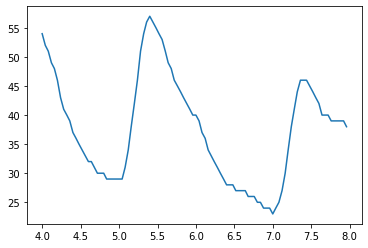

In [4]:
import matplotlib.pyplot as plt

plt.plot(df['Trans: Wave']);

Text(0.5, 0, 'time (s)')

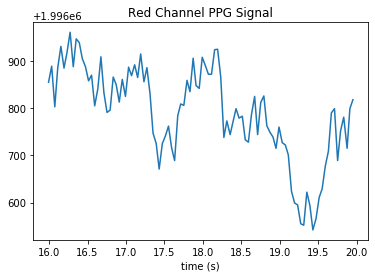

In [9]:
plt.plot(df['Reflect: Red']);
plt.title('Red Channel PPG Signal')
plt.xlabel('time (s)')

Text(0.5, 0, 'time (s)')

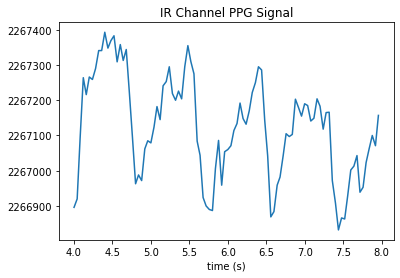

In [7]:
plt.plot(df['Reflect: IR']);
plt.title('IR Channel PPG Signal')
plt.xlabel('time (s)')

In [5]:
# df['Reflect: Green'] -= df['Reflect: Green'].mean()
# plt.plot(df['Reflect: Green']);

In [6]:
samples = len(df.index)
time = (df.index[-1] - df.index[0])

In [7]:
sr = samples / time
sr

25.27708767343743

[52.865610122680664, 57.51753330230713, 62.33309268951416]
62.33309268951416


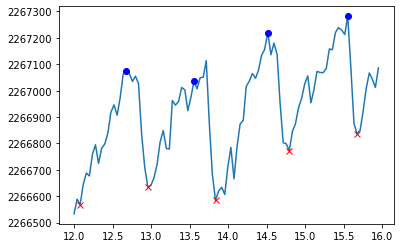

In [8]:
from scipy import signal
import numpy as np

# doesn't give result I want when putting asa param for find_peaks -- not really sure why
width = 60 / bpm

dt = time / samples
dist = width / dt
# give room for error
dist -= .1 * dist

ir = df['Reflect: IR'].to_numpy()
inv_ir = -ir
trough_idx, _ = signal.find_peaks(inv_ir, distance=dist)
peak_idx, _ = signal.find_peaks(ir, distance=dist)

plt.plot(df['Reflect: IR']);
plt.plot(df.index[trough_idx], ir[trough_idx], 'rx');
plt.plot(df.index[peak_idx], ir[peak_idx], 'bo')

periods = []
for i in range(len(peak_idx) - 1):
    period = df.index[peak_idx[i + 1]] - df.index[peak_idx[i]]
    periods.append(period)
print(list(map(lambda x: x * 60, periods)))
avg_period = sum(periods) / len(periods)
print(period * 60)

In [9]:
import numpy as np
import scipy.fftpack

x = df.index
y = df['Reflect: IR']
dt = time / samples

# reconstruct df.index to ensure perfect spacing (should not have that much difference? may be a problem, not sure)
t = np.arange(df.index[0], df.index[-1], dt)
n = len(t)

C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


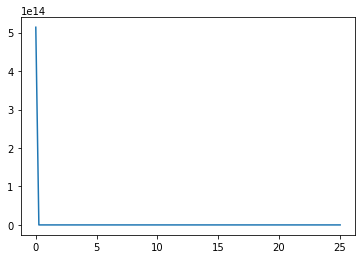

In [10]:
# fourier transform - code from https://www.youtube.com/watch?v=s2K1JfNR7Sc&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=20
fhat = np.fft.fft(y,n)
PSD = (fhat * np.conj(fhat)) / n
freq = (1/(dt*n)) * np.arange(n)

plt.plot(freq,PSD);

In [11]:
indices = PSD > 300
PSDclean = PSD * indices
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)
ffilt = np.real(ffilt)

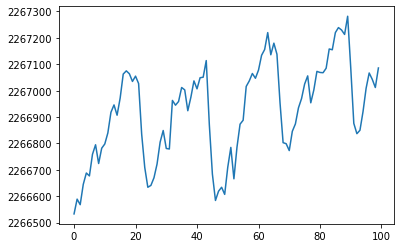

In [12]:
import heartpy as hp
plt.plot(ffilt)

In [ ]:
from scipy import signal
import numpy as np

# doesn't give result I want when putting asa param for find_peaks -- not really sure why
# bpm here is taken directly from transmission pulseox, in practice we would use estimate from heartpy process? doesn't seem great for error
width = 60 / bpm
# so dist is used instead
dt = time / samples
dist = width / dt
# give room for error
dist -= .1 * dist

# find peaks and troughs
ir = clean_ir_signal
inv_ir = -ir
trough_idx, _ = signal.find_peaks(inv_ir, distance=dist)
peak_idx, _ = signal.find_peaks(ir, distance=dist)

plt.plot(df.index, clean_ir_signal);
plt.plot(df.index[trough_idx], ir[trough_idx], 'rx');
plt.plot(df.index[peak_idx], ir[peak_idx], 'bo')

irDc = []
irAc = []

# go through for every peak-trough-peak group in our sequence
for i in range(len(trough_idx) - 1):
    # pick two arbitrary troughs and the peak in between
    tidx0 = trough_idx[i]
    tidx1 = trough_idx[i + 1]
    pidx = peak_idx[i]
    j = i
    while pidx < tidx0:
        j += 1
        pidx = peak_idx[j]

    # find parameters for best fit line between two trough
    m = (ir[tidx1] - ir[tidx0]) / (df.index[tidx1] - df.index[tidx0])
    b = ir[tidx0] - m * df.index[tidx0]

    # test line
    testx = np.linspace(df.index[tidx0], df.index[tidx1], 10)
    testy = testx * m + b
    plt.plot(testx, testy)

    # find AC and DC components using the best fit line
    peakVal = ir[pidx]
    irDcTemp = m * df.index[pidx] + b
    irAcTemp = peakVal - irDcTemp
    
    irDc.append(irDcTemp)
    irAc.append(irAcTemp)

irDcVar = np.var(irDc)
irAcVar = np.var(irAc)
print(irDcVar, irAcVar)

plt.xlabel('time (s)')
plt.title('IR Channel Peak/Trough Detection')

irDc = sum(irDc) / len(irDc)
irAc = sum(irAc) / len(irAc)

In [15]:
# bandpass filter

import heartpy as hp
# sampling at 50Hz, but averaging every 2 samples together for a single output, and so sampling rate is effectively 25 hz?
##### import heartpy as hp
filtered_red = hp.filter_signal(df['Reflect: Red'], 
                                  cutoff = [.7, 4], 
                                  filtertype = 'bandpass',
                                  sample_rate = 25, 
                                  order = 4,
                                  return_top = False)

filtered_ir = hp.filter_signal(df['Reflect: IR'],
                              cutoff = [.7, 4],
                              filtertype = 'bandpass',
                              sample_rate = 25,
                              order = 4,
                              return_top = False)

# filtered_green = hp.filter_signal(df['Reflect: Green'],
#                               cutoff = [.8, 2.5],
#                               filtertype = 'bandpass',
#                               sample_rate = sr,
#                               order = 4,
#                               return_top = False)


<Figure size 432x288 with 0 Axes>

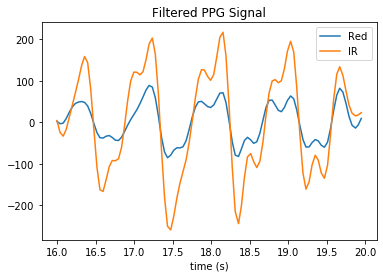

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(df.index, filtered_red)
# plt.plot(df.index, df['Trans: Wave'])
plt.plot(df.index, filtered_ir)
#plt.plot(df.index, filtered_green)
plt.title('Filtered PPG Signal')
plt.xlabel('time (s)')
plt.legend(['Red', 'IR', 'Green'])
plt.figure(2)


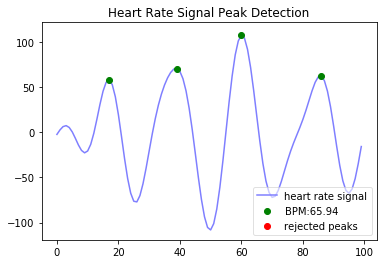

error: -0.01581748189082035


In [15]:
wd_red, m_red = hp.process(filtered_red, sample_rate = sr)
hp.plotter(wd_red, m_red)
bpm_test = m_red['bpm']
error = (bpm_test - bpm) / bpm
print(f'error: {error}')

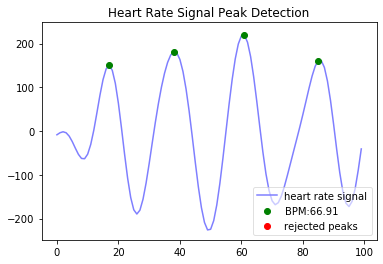

error: -0.0013442095656855532


In [16]:
wd_ir, m_ir = hp.process(filtered_ir, sample_rate = sr)
hp.plotter(wd_ir, m_ir)
bpm_test = m_ir['bpm']
error = (bpm_test - bpm) / bpm
print(f'error: {error}')

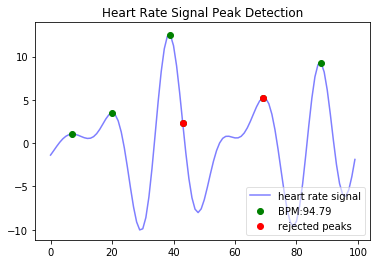

In [17]:
wd, m = hp.process(filtered_trans, sample_rate=sr)
hp.plotter(wd, m)

C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\ma\core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


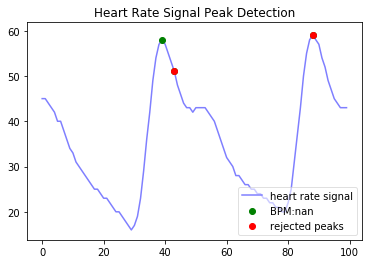

In [18]:
a = df['Trans: Wave'].to_numpy()
wd, m = hp.process(a, sample_rate=sr)
hp.plotter(wd, m)